In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

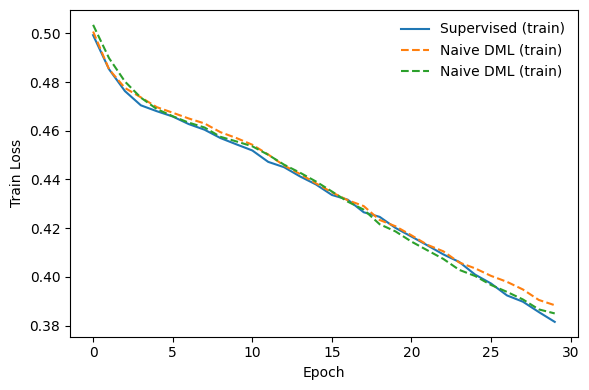

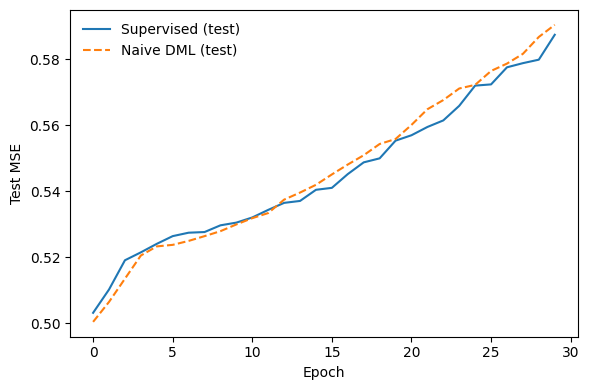

Final Supervised Test MSE: 0.587350
Final Naive DML Test MSE: 0.590359


In [36]:
# =========================
# Single-cell experiment
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# -------------------------
# Dataset
# -------------------------
class ToyOperatorDataset(Dataset):
    def __init__(self, n_samples=2000, in_dim=10, out_dim=20):
        self.u = torch.randn(n_samples, in_dim)
        A = torch.randn(in_dim, out_dim)
        self.y = torch.sin(self.u @ A)

    def __len__(self):
        return len(self.u)

    def __getitem__(self, idx):
        return self.u[idx], self.y[idx]


# -------------------------
# Operator Network
# -------------------------
class SimpleOperator(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, u):
        return self.net(u)


def dml_loss(pred_i, pred_j, targets, alpha=1.0, T=1.0):
    mse = F.mse_loss(pred_i, targets)

    log_p_i = F.log_softmax(pred_i / T, dim=1)
    p_j     = F.softmax(pred_j.detach() / T, dim=1)

    kl = F.kl_div(log_p_i, p_j, reduction="batchmean") * T*T
    return mse + alpha * kl


# -------------------------
# Training / Evaluation
# -------------------------
def train_supervised(model, loader, optimizer, device):
    model.train()
    total = 0.0
    for u, y in loader:
        u, y = u.to(device), y.to(device)
        pred = model(u)
        loss = F.mse_loss(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item()
    return total / len(loader)


def train_naive_dml(model1, model2, loader, optimizer1, optimizer2, device, alpha=1.0, T=1.0):
    model1.train()
    model2.train()
    total_loss1 = 0.0
    total_loss2 = 0.0
    
    for u, y in loader:
        u, y = u.to(device), y.to(device)

        logits1 = model1(u)
        logits2 = model2(u)

        loss1 = dml_loss(logits1, logits2, y, alpha=alpha, T=T)
        loss2 = dml_loss(logits2, logits1, y, alpha=alpha, T=T)

        optimizer1.zero_grad()
        optimizer2.zero_grad()

        loss1.backward()
        loss2.backward()

        optimizer1.step()
        optimizer2.step()

        total_loss1 += loss1.item()
        total_loss2 += loss2.item()

    return total_loss1 / len(loader), total_loss2 / len(loader)


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    mse = 0.0
    for u, y in loader:
        u, y = u.to(device), y.to(device)
        pred = model(u)
        mse += F.mse_loss(pred, y).item()
    return mse / len(loader)


# -------------------------
# Main experiment
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 30

train_ds = ToyOperatorDataset(2000)
test_ds  = ToyOperatorDataset(500)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

# ----- Supervised -----
model_sup = SimpleOperator(10, 64, 20).to(device)
opt_sup = torch.optim.Adam(model_sup.parameters(), lr=1e-3)

sup_train_losses = []
sup_test_losses  = []

for ep in range(epochs):
    train_loss = train_supervised(model_sup, train_loader, opt_sup, device)
    test_loss  = evaluate(model_sup, test_loader, device)

    sup_train_losses.append(train_loss)
    sup_test_losses.append(test_loss)

# ----- Naive DML -----
model1 = SimpleOperator(10, 64, 20).to(device)
model2 = SimpleOperator(10, 64, 20).to(device)

opt1 = torch.optim.Adam(model1.parameters(), lr=1e-3)
opt2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

dml_train_losses = []
dml_test_losses  = []

for ep in range(epochs):
    train_loss = train_naive_dml(
        model1, model2,
        train_loader,
        opt1, opt2,
        device, 
        alpha=1.0, 
        T=1.0
    )
    test_loss = evaluate(model1, test_loader, device)

    dml_train_losses.append(train_loss)
    dml_test_losses.append(test_loss)


# -------------------------
# Plot: Train Loss
# -------------------------
plt.figure(figsize=(6,4))
plt.plot(sup_train_losses, label="Supervised (train)")
plt.plot(dml_train_losses, linestyle="--", label="Naive DML (train)")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# -------------------------
# Plot: Test Loss
# -------------------------
plt.figure(figsize=(6,4))
plt.plot(sup_test_losses, label="Supervised (test)")
plt.plot(dml_test_losses, linestyle="--", label="Naive DML (test)")
plt.xlabel("Epoch")
plt.ylabel("Test MSE")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

print(f"Final Supervised Test MSE: {sup_test_losses[-1]:.6f}")
print(f"Final Naive DML Test MSE: {dml_test_losses[-1]:.6f}")
